In [18]:
# hybrid_chatbot_model.py

import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import numpy as np
import joblib
import matplotlib.pyplot as plt

# ===== Step 1: Load Data =====
df = pd.read_csv("Analytics_Acquisition Chatbot_data_fin_epic6.csv")


In [19]:
df.head()

,Qualifications,Employment_Type,Age,City,State,Pincode,Gender,Product_Code,Loan_Amount,LTV,Resident_Type,Net_salary,Final_Tier,Make_Code,Model_Description,Model_Variant,PAST_LOANS_ACTIVE,Decision
0,SSC,AGR,47.0,Medak,AP,502110,Male,MO,59300,69.76,O,39000.0,07 Rural,MOPEDS,TVS XL 100 HD ITS BSVI - WINNER EDITION,XL 100CC,PAST_LOANS_ACTIVE,APPROVED
1,UG,SAL,30.0,Gurbabadi,AP,503002,Male,MC,153839,84.99,O,25000.0,05 Urban,APACHE,APACHE 200 4V 2CH - R MODE BSVI,RTR 200CC,PAST_LOANS_ACTIVE,APPROVED
2,GRAD,NREGI,24.0,Nizampet,AP,500090,Male,SC,77958,64.97,R,35000.0,04 Metro,JUPITER,JUPITER ZX BSVI - AOL - DRUM,110 CC,PAST_LOANS_ACTIVE,APPROVED
3,UG,SAL,44.0,Tandur,AP,501141,Male,SC,99921,84.68,O,25000.0,07 Rural,JUPITER,JUPITER 125 BSVI - DISC,125 CC DISC,PAST_LOANS_ACTIVE,APPROVED
4,SSC,SAL,41.0,Hunwada,AP,509334,Male,SC,96482,75.38,O,35000.0,07 Rural,JUPITER,JUPITER 125 BSVI DISC SXC U566,125CC DISC,PAST_LOANS_ACTIVE,APPROVED


In [20]:
df.describe()

,Age,Pincode,Loan_Amount,LTV,Net_salary
count,109415.000000,109434.000000,109434.000000,109434.000000,109411.000000
mean,34.426477,542453.052104,89325.589643,77.714197,33983.523969
std,10.731784,217350.853693,25555.232837,12.698717,20184.836733
min,18.000000,110001.000000,16569.000000,0.000000,0.000000
25%,25.000000,332027.000000,69585.750000,72.170000,25000.000000
50%,32.000000,572228.000000,90156.500000,81.360000,30000.000000
75%,42.000000,752054.000000,106827.750000,86.060000,37000.000000
max,69.000000,855117.000000,286847.000000,99.600000,980000.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109434 entries, 0 to 109433
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Qualifications     109408 non-null  object 
 1   Employment_Type    109407 non-null  object 
 2   Age                109415 non-null  float64
 3   City               109411 non-null  object 
 4   State              109434 non-null  object 
 5   Pincode            109434 non-null  int64  
 6   Gender             109434 non-null  object 
 7   Product_Code       109434 non-null  object 
 8   Loan_Amount        109434 non-null  int64  
 9   LTV                109434 non-null  float64
 10  Resident_Type      109415 non-null  object 
 11  Net_salary         109411 non-null  float64
 12  Final_Tier         109411 non-null  object 
 13  Make_Code          109431 non-null  object 
 14  Model_Description  109431 non-null  object 
 15  Model_Variant      109431 non-null  object 
 16  PA

In [22]:
rejected_rows = df[df['Decision'] == 'DECLINED']
len(rejected_rows)

6048

In [23]:

# --- IMPROVEMENT 1: Use more features from the provided document ---
features = ["Age", "Pincode", "Employment_Type", "Net_salary",
            "Loan_Amount", "PAST_LOANS_ACTIVE", "Gender",
            "State", "Product_Code", "Qualifications"]
target = "Decision"

# --- Add a new engineered feature: loan_to_income_ratio ---
# This feature provides a simple metric that is highly predictive of risk.
df["loan_to_income_ratio"] = df["Loan_Amount"] / df["Net_salary"]


In [24]:

# Update features list with the new engineered feature
features.append("loan_to_income_ratio")

# Filter out ineligible users based on the policy in the PDF
df = df[df["Age"] >= 18]
df = df[df["Age"] <= 60]

# Drop rows where the target variable is missing
df = df.dropna(subset=[target]).copy()

# Convert the target variable to a binary format (0 for declined, 1 for approved)
df[target] = df[target].map({"APPROVED": 1, "DECLINED": 0})

# Fill missing values to ensure the model can handle the data
for col in features:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna("Unknown")
    else:
        # Handle potential division by zero errors for the new feature
        if col == "loan_to_income_ratio":
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        df[col] = df[col].fillna(df[col].median())

cat_features = [col for col in features if df[col].dtype == 'object']


In [25]:

# ===== Step 2: Split Data =====
# Split the data into training and testing sets, stratifying to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42, stratify=df[target]
)

# ===== Step 3: Encode Categorical Features =====
# Use LabelEncoder to convert categorical features to numerical values
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    # Fit the encoder on all unique values from both train and test to prevent errors from unknown categories
    all_data = pd.concat([X_train[col], X_test[col]])
    le.fit(all_data.unique())
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le


In [26]:

# ===== Step 4: Address Class Imbalance with SMOTE =====
# --- IMPROVEMENT 2: Change SMOTE sampling strategy to a more moderate value ---
# A value of 0.6 is a compromise between oversampling and maintaining the original data's integrity.
smote = SMOTE(random_state=42, sampling_strategy=0.6)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)



In [27]:
# ===== Step 5: Train LightGBM with Hyperparameter Tuning =====
# --- IMPROVEMENT 3: Use GridSearchCV to find the best hyperparameters ---
# This ensures we get the optimal model configuration for our specific dataset.
neg_count = sum(y_train_res == 0)
pos_count = sum(y_train_res == 1)
scale_pos_weight = neg_count / pos_count

lgb_model = lgb.LGBMClassifier(objective='binary',
                               metric='auc',
                               n_estimators=500,
                               random_state=42,
                               scale_pos_weight=scale_pos_weight)

# Define a grid of parameters to search over
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [5, 7, 10],
    'reg_alpha': [0, 0.1, 0.5]
}


In [28]:

# Perform the grid search
grid_search = GridSearchCV(lgb_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res,
                eval_set=[(X_test, y_test)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=20)])

# Select the best model found by the grid search
lgb_model_tuned = grid_search.best_estimator_
print(f"\nBest parameters found by GridSearchCV: {grid_search.best_params_}")



Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Number of positive: 81824, number of negative: 49094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 130918, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625002 -> initscore=0.510834
[LightGBM] [Info] Start training from score 0.510834
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [29]:
# ===== Step 6: Define Business Rules Function =====
def apply_business_rules(row):
    # Example hard rejection rules based on business logic
    if row["Age"] < 21:
        return 0
    if row["Net_salary"] < 15000:
        return 0
    # --- IMPROVEMENT 4: Refined business rule with a less strict threshold ---
    # Raising the loan-to-income ratio to 15 reduces the number of false rejections
    if row["loan_to_income_ratio"] > 15:
        return 0
    return None  # Let the ML model decide


In [30]:

# ===== Step 7: Auto threshold tuning =====
# We will tune the threshold to optimize for the F1-score of the minority class (Declined)
y_pred_proba = []
for i, row in X_test.iterrows():
    # Apply business rules first
    rule_result = apply_business_rules(row)
    if rule_result is not None:
        y_pred_proba.append(0.0 if rule_result == 0 else 1.0)
    else:
        # Use the tuned model's prediction
        proba = lgb_model_tuned.predict_proba([row[features]])[0][1]
        y_pred_proba.append(proba)

best_threshold = 0.5
best_f1_decline = 0
for t in np.arange(0.3, 0.81, 0.01):
    y_pred_class_temp = (np.array(y_pred_proba) >= t).astype(int)
    f1_decline = f1_score(y_test, y_pred_class_temp, pos_label=0, average="binary")
    if f1_decline > best_f1_decline:
        best_f1_decline = f1_decline
        best_threshold = t

print(f"\nBest Threshold: {best_threshold:.2f} (Declined F1 = {best_f1_decline:.4f})")

# Apply the best threshold to get final predictions
y_pred_class = (np.array(y_pred_proba) >= best_threshold).astype(int)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best Threshold: 0.80 (Declined F1 = 0.1889)


In [31]:

# ===== Step 8: Evaluation =====
# Calculate and print various evaluation metrics
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))



AUC-ROC Score: 0.7076

Confusion Matrix:
[[  497   705]
 [ 3563 16893]]

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.41      0.19      1202
           1       0.96      0.83      0.89     20456

    accuracy                           0.80     21658
   macro avg       0.54      0.62      0.54     21658
weighted avg       0.91      0.80      0.85     21658




Feature importance chart saved as feature_importance.png


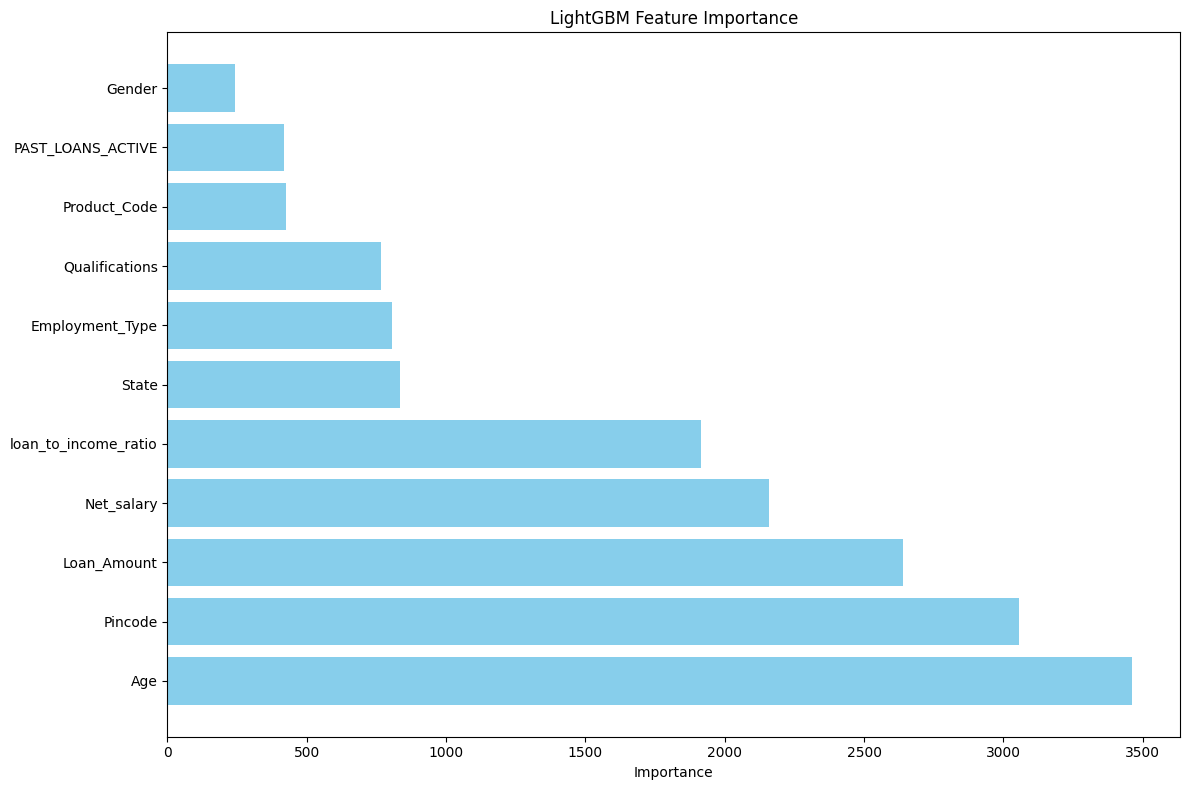

In [32]:
# ===== Step 9: Feature Importance Plotting =====
# --- IMPROVEMENT 5: Visualize feature importance to gain insights ---
importances = lgb_model_tuned.feature_importances_
feature_names = lgb_model_tuned.feature_name_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("\nFeature importance chart saved as feature_importance.png")


In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ks_stat = max(tpr - fpr)
print("KS Statistic:", ks_stat)


KS Statistic: 0.3260193381256764
